In [1]:
!pip install ucimlrepo


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from ucimlrepo import fetch_ucirepo
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
# fetch dataset
breast_cancer = fetch_ucirepo(id=14)

# data (as pandas dataframes)
X = breast_cancer.data.features
y = breast_cancer.data.targets

# metadata
print(breast_cancer.metadata)

# variable information
print(breast_cancer.variables)

{'uci_id': 14, 'name': 'Breast Cancer', 'repository_url': 'https://archive.ics.uci.edu/dataset/14/breast+cancer', 'data_url': 'https://archive.ics.uci.edu/static/public/14/data.csv', 'abstract': 'This breast cancer domain was obtained from the University Medical Centre, Institute of Oncology, Ljubljana, Yugoslavia. This is one of three domains provided by the Oncology Institute that has repeatedly appeared in the machine learning literature. (See also lymphography and primary-tumor.)', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 286, 'num_features': 9, 'feature_types': ['Categorical'], 'demographics': ['Age'], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1988, 'last_updated': 'Thu Mar 07 2024', 'dataset_doi': '10.24432/C51P4M', 'creators': ['Matjaz Zwitter', 'Milan Soklic'], 'intro_paper': None, 'additional_info': {'summary': 'Thi

In [4]:
# fix values
X.fillna('?', inplace=True)
X['tumor-size'] = X['tumor-size'].replace({'9-May': '05-9', '14-Oct': '10-14'})
X['inv-nodes'] = X['inv-nodes'].replace({'11-Sep': '9-11', '14-Dec': '12-14', '5-Mar': '3-5', '8-Jun': '6-8'})

In [5]:
class CustomLabelEncoder:
    def __init__(self):
        self.class_mapping = {}

    def fit(self, data):
        unique_classes = sorted(set(data))  # Sort the data and remove duplicates
        self.class_mapping = {label: idx for idx, label in enumerate(unique_classes)}

    def transform(self, data):
        return [self.class_mapping.get(item, -1)  # Return -1 or any other placeholder for unseen categories
                for item in data]

    def inverse_transform(self, encoded_data):
        inv_map = {v: k for k, v in self.class_mapping.items()}
        return [inv_map.get(item, 'Unknown')  # Handle unknown items
                for item in encoded_data]

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [6]:
class RangeEncoder:
    def __init__(self):
        self.class_mapping = {}

    def fit(self, data):
        unique_classes = sorted(set(data))  # Sort the data and remove duplicates
        class_map = {int(c.split('-')[0]):c for c in unique_classes}
        temp_classes = sorted([int(c.split('-')[0]) for c in unique_classes])

        self.class_mapping = {class_map[label]: idx for idx, label in enumerate(temp_classes)}

    def transform(self, data):
        return [self.class_mapping.get(item, -1)  # Return -1 or any other placeholder for unseen categories
                for item in data]

    def inverse_transform(self, encoded_data):
        inv_map = {v: k for k, v in self.class_mapping.items()}
        return [inv_map.get(item, 'Unknown')  # Handle unknown items
                for item in encoded_data]

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [7]:
# label encoder
enc_age = CustomLabelEncoder()
X['age'] = enc_age.fit_transform(X['age'])
enc_meno = CustomLabelEncoder()
X['menopause'] = enc_meno.fit_transform(X['menopause'])
enc = CustomLabelEncoder()
X['tumor-size'] = enc.fit_transform(X['tumor-size'])
enc_nodecaps = CustomLabelEncoder()
X['node-caps'] = enc.fit_transform(X['node-caps'])
X['breast'] = enc.fit_transform(X['breast'])
X['breast-quad'] = enc.fit_transform(X['breast-quad'])
X['irradiat'] = enc.fit_transform(X['irradiat'])
range_enc = RangeEncoder()
X['inv-nodes'] = range_enc.fit_transform(X['inv-nodes'])

In [8]:
# code to replicate fingerprint embedding with NCorrFP scheme
from NCorrFP_scheme.NCorrFP import NCorrFP

scheme = NCorrFP(gamma=1, fingerprint_bit_length=16)
# data = "datasets/breast_cancer_full.csv"
fp_data = scheme.insertion('breast-cancer', primary_key_name='Id', secret_key=501, recipient_id=4,
#                                          outfile='NCorrFP_scheme/outfiles/fp_data_blind_corr_inv_node_501.csv',
                                          correlated_attributes=[['inv-nodes', 'node-caps'], ['age', 'menopause']])

# sanity check if the detection works
# suspect = scheme.detection(fp_data, secret_key=501, primary_key='Id',
#                                correlated_attributes=['inv-nodes', 'node-caps'],
#                                original_columns=["age","menopause","tumor-size","inv-nodes","node-caps","deg-malig","breast","breast-quad",
#     "irradiat","recurrence"])

Start the NCorr fingerprint insertion algorithm...
	gamma: 1
	correlated attributes: [['inv-nodes', 'node-caps'], ['age', 'menopause']]

Generated fingerprint for recipient 4: 1001111001101110

Generated fingerprint for recipient 4: 1001111001101110
Inserting the fingerprint...

Training balltrees in: 0.04 sec.
Fingerprint inserted.
Runtime: 982.01 ms.


In [9]:
enc_nodecaps = CustomLabelEncoder()
fp_data['node-caps'] = enc_nodecaps.fit_transform(fp_data['node-caps'])
enc_invnodes = RangeEncoder()
fp_data['inv-nodes'] = enc_invnodes.fit_transform(fp_data['inv-nodes'])

In [10]:
# first decode the values
X['node-caps'] = enc_nodecaps.inverse_transform(X['node-caps'])
X['inv-nodes'] = enc_invnodes.inverse_transform(X['inv-nodes'])
fp_data['node-caps'] = enc_nodecaps.inverse_transform(fp_data['node-caps'])
fp_data['inv-nodes'] = enc_invnodes.inverse_transform(fp_data['inv-nodes'])

In [11]:
X['age'] = enc_age.inverse_transform(X['age'])

In [12]:
X['menopause'] = enc_meno.inverse_transform(X['menopause'])

[Text(0, 0.5, '0-2'),
 Text(0, 1.5, '12-14'),
 Text(0, 2.5, '15-17'),
 Text(0, 3.5, '24-26'),
 Text(0, 4.5, '3-5'),
 Text(0, 5.5, '6-8'),
 Text(0, 6.5, '9-11')]

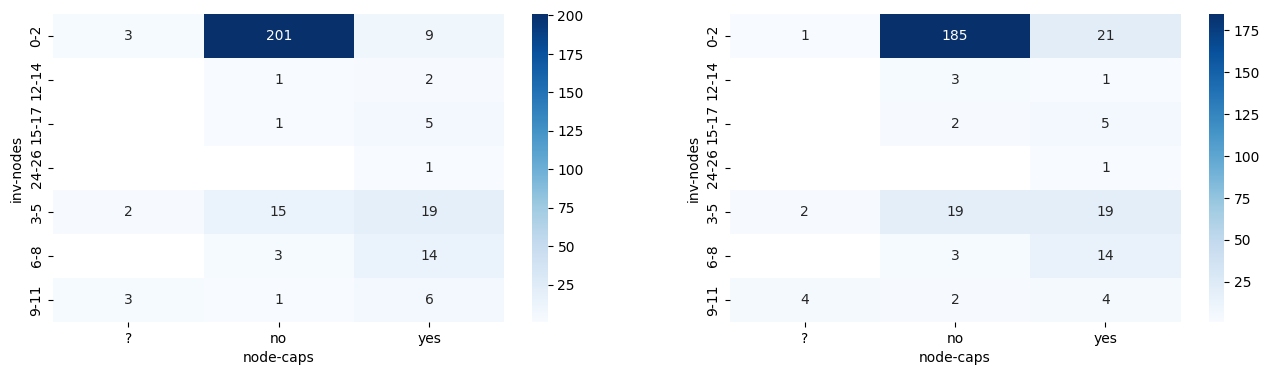

In [13]:
# E.g., inv-nodes and node-caps
fig, axs = plt.subplots(1, 2, figsize=(16,4))
axs = axs.flat
#fig.suptitle('Pairwise attribute distributions')

############
# ORIGINAL #
############
# node-caps vs inv-nodes
df_2dhist = pd.DataFrame({
    x_label: grp['inv-nodes'].value_counts()
    for x_label, grp in X.groupby('node-caps')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[0])
axs[0].set_xlabel('node-caps')
axs[0].set_ylabel('inv-nodes')
axs[0].set_yticklabels(axs[0].get_yticklabels())
#axs[0].set_title('Original data')


# NN scheme with correlations
df_2dhist = pd.DataFrame({
    x_label: grp['inv-nodes'].value_counts()
    for x_label, grp in fp_data.groupby('node-caps')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[1])
axs[1].set_xlabel('node-caps')
axs[1].set_ylabel('inv-nodes')
axs[1].set_yticklabels(axs[1].get_yticklabels())
#axs[3].set_title('NN scheme using correlations')

[Text(0.5, 0, '20-29'),
 Text(1.5, 0, '30-39'),
 Text(2.5, 0, '40-49'),
 Text(3.5, 0, '50-59'),
 Text(4.5, 0, '60-69'),
 Text(5.5, 0, '70-79')]

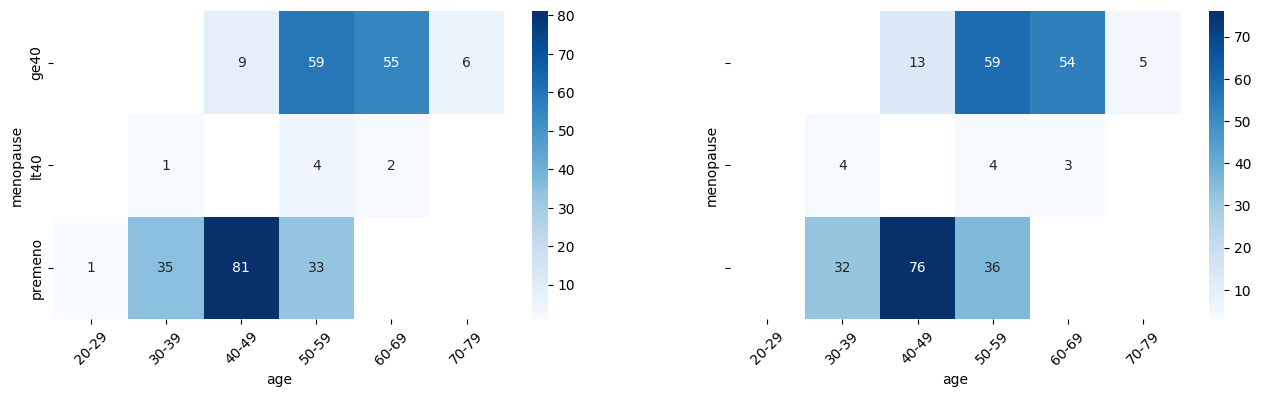

In [14]:
# We investigate the pairwise attribute distributions of correlated attributes.
# E.g., age and menopause
fig, axs = plt.subplots(1, 2, figsize=(16,4), sharey='all')
axs = axs.flat
#fig.suptitle('Pairwise attribute distributions')

############
# ORIGINAL #
############
# age vs menopause
df_2dhist = pd.DataFrame({
    x_label: grp['menopause'].value_counts()
    for x_label, grp in X.groupby('age')
})
sns.heatmap(df_2dhist, cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[0])
axs[0].set_xlabel('age')
axs[0].set_ylabel('menopause')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
#axs[0].set_title('Original data')
columns = df_2dhist.columns

# NN scheme with correlations
df_2dhist = pd.DataFrame({
    x_label: grp['menopause'].value_counts()
    for x_label, grp in fp_data.groupby('age')
})
df_2dhist['20-29'] = [np.nan, np.nan, np.nan]
df_2dhist = df_2dhist[columns]
sns.heatmap(df_2dhist, cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[1])
axs[1].set_xlabel('age')
axs[1].set_ylabel('menopause')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)
#axs[3].set_title('NN scheme using correlations')

## Hamming vs Minkowski

In [17]:
# code to replicate fingerprint embedding with NCorrFP scheme using minkowski distance
from NCorrFP_scheme.NCorrFP import NCorrFP

scheme = NCorrFP(gamma=1, fingerprint_bit_length=16, distance_metric_discrete='hamming')
# data = "datasets/breast_cancer_full.csv"
fp_data_mnkw = scheme.insertion('breast-cancer', primary_key_name='Id', secret_key=501, recipient_id=4,
#                                          outfile='NCorrFP_scheme/outfiles/fp_data_blind_corr_inv_node_501.csv',
                                          correlated_attributes=[['inv-nodes', 'node-caps'], ['age', 'menopause']])

# sanity check if the detection works
# suspect = scheme.detection(fp_data, secret_key=501, primary_key='Id',
#                                correlated_attributes=['inv-nodes', 'node-caps'],
#                                original_columns=["age","menopause","tumor-size","inv-nodes","node-caps","deg-malig","breast","breast-quad",
#     "irradiat","recurrence"])

Start the NCorr fingerprint insertion algorithm...
	gamma: 1
	correlated attributes: [['inv-nodes', 'node-caps'], ['age', 'menopause']]

Generated fingerprint for recipient 4: 1001111001101110

Generated fingerprint for recipient 4: 1001111001101110
Inserting the fingerprint...

Training balltrees in: 0.02 sec.
Fingerprint inserted.
Runtime: 1.28 sec.


[Text(0, 0.5, '0-2'),
 Text(0, 1.5, '12-14'),
 Text(0, 2.5, '15-17'),
 Text(0, 3.5, '24-26'),
 Text(0, 4.5, '3-5'),
 Text(0, 5.5, '6-8'),
 Text(0, 6.5, '9-11')]

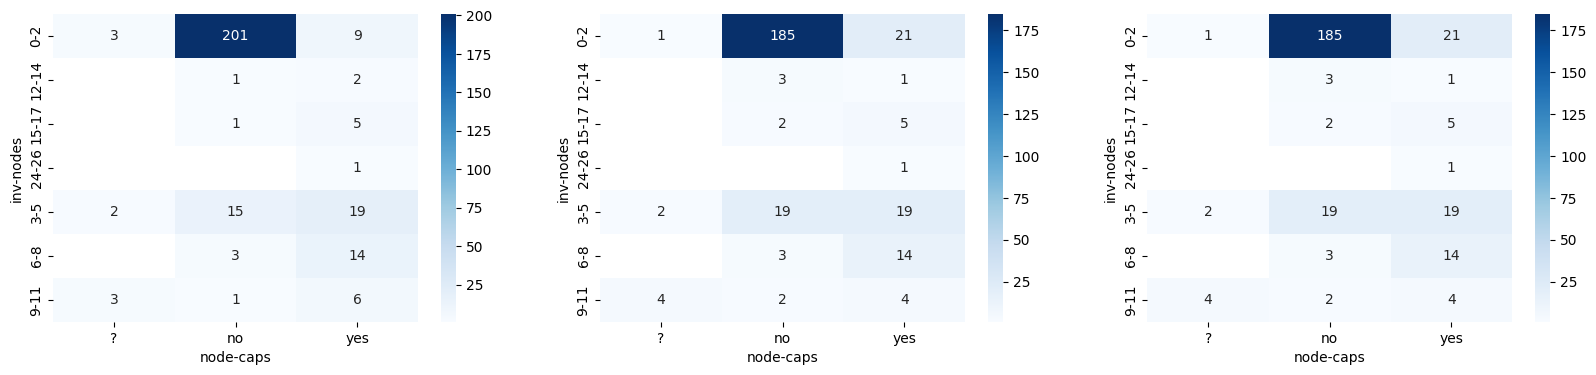

In [18]:
# E.g., inv-nodes and node-caps
fig, axs = plt.subplots(1, 3, figsize=(20,4))
axs = axs.flat
#fig.suptitle('Pairwise attribute distributions')

############
# ORIGINAL #
############
# node-caps vs inv-nodes
df_2dhist = pd.DataFrame({
    x_label: grp['inv-nodes'].value_counts()
    for x_label, grp in X.groupby('node-caps')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[0])
axs[0].set_xlabel('node-caps')
axs[0].set_ylabel('inv-nodes')
axs[0].set_yticklabels(axs[0].get_yticklabels())
#axs[0].set_title('Original data')


# NN scheme with correlations -- HAMMING
df_2dhist = pd.DataFrame({
    x_label: grp['inv-nodes'].value_counts()
    for x_label, grp in fp_data.groupby('node-caps')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[1])
axs[1].set_xlabel('node-caps')
axs[1].set_ylabel('inv-nodes')
axs[1].set_yticklabels(axs[1].get_yticklabels())
#axs[3].set_title('NN scheme using correlations')

# NN scheme with correlations -- MINKOWSKI
df_2dhist = pd.DataFrame({
    x_label: grp['inv-nodes'].value_counts()
    for x_label, grp in fp_data_mnkw.groupby('node-caps')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[2])
axs[2].set_xlabel('node-caps')
axs[2].set_ylabel('inv-nodes')
axs[2].set_yticklabels(axs[1].get_yticklabels())
#axs[3].set_title('NN scheme using correlations')